In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

import tensorflow as tf
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [168]:
%matplotlib inline

In [3]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (10,6)

# Data Preprocessing:

In [4]:
file = './data/surrModel_trainingDB_uF0_PS1_ss100k.pkl'
with open(file, 'rb') as f:
    train_data = pickle.load(f)
training_in = train_data['input']
training_out = train_data['output']

In [5]:
input_names = {}
input_names_raw = training_in.keys().to_list()

output_names = {}
output_names_raw = training_out.keys().to_list()

input_names['demand'] = [name_i for name_i in input_names_raw if name_i.startswith('J')]
input_names['pumps'] = [name_i for name_i in input_names_raw if name_i.startswith('PU')]
input_names['valves'] = [name_i for name_i in input_names_raw if name_i.startswith('V')]
input_names['tanks'] = [name_i for name_i in input_names_raw if name_i.startswith('T')]

output_names['pressure'] = [name_i for name_i in output_names_raw if name_i.startswith('J')]
output_names['tanks'] = [name_i for name_i in output_names_raw if name_i.startswith('T')]
output_names['power'] = [name_i for name_i in output_names_raw if name_i.startswith('PU')]

## Check Data and filter

``data_filter`` holds a ``bool`` for every entry of the data matrices. It is set to zero if any of the conditions are not satisfied. All data is filtered in the end to exclude faulty values.

In [6]:
data_filter = np.ones(training_in.shape[0], dtype=bool)

### Junctions:
Pressure and demand.

In [7]:
junction_demand = training_in[input_names['demand']]
junction_pressure = training_out[output_names['pressure']]

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

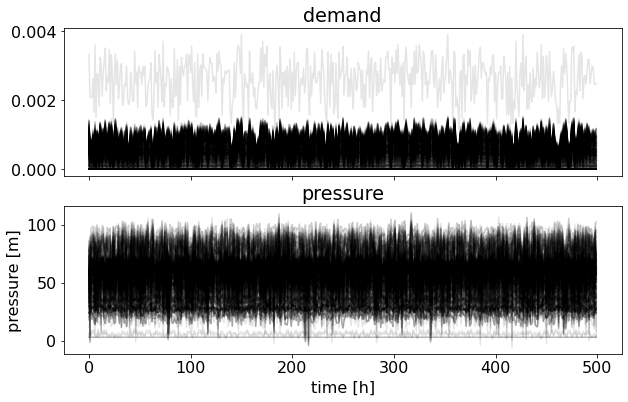

In [8]:
fig, ax = plt.subplots(2,1, sharex=True)
junction_demand.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='demand', xlabel='time [h]')
junction_pressure.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

In [9]:
#data_filter = data_filter & np.all(np.abs(junction_pressure)<1e3, axis=1)
#data_filter = data_filter & np.all(junction_pressure>0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

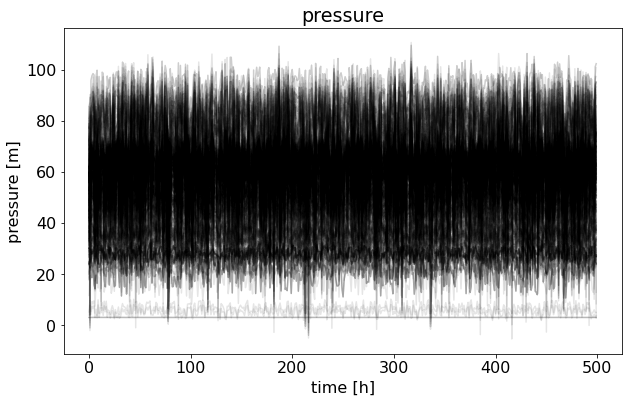

In [10]:
junction_pressure[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

### Tank levels:

<AxesSubplot:title={'center':'next tank levels'}, xlabel='time [h]', ylabel='delta height [m]'>

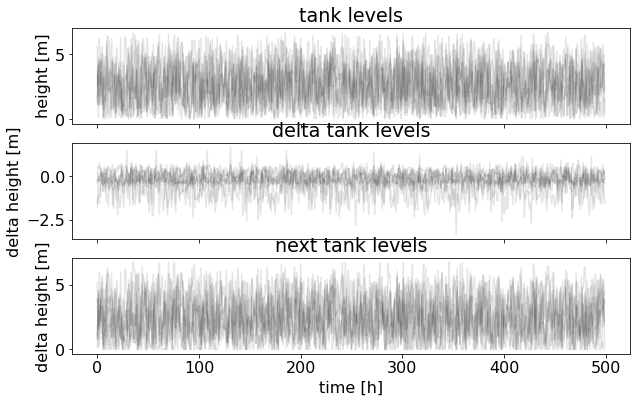

In [11]:
fig, ax = plt.subplots(3,1, sharex = True)
tank_level = training_in[input_names['tanks']]
dtank_level = training_out[output_names['tanks']]
dtank_level.columns = tank_level.columns
tank_level_next = tank_level+dtank_level
tank_level.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='tank levels', xlabel='time [h]', ylabel='height [m]')
dtank_level.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='delta tank levels', xlabel='time [h]', ylabel='delta height [m]')
tank_level_next.head(500).plot(ax=ax[2],legend=False, color='k', alpha=0.1, title='next tank levels', xlabel='time [h]', ylabel='delta height [m]')

In [12]:
100*(tank_level_next.mean()-tank_level.mean())/tank_level.mean()

T3    -1.690607
T1    -8.239207
T7   -27.415509
T6    -2.852221
T5    -8.000860
T2     7.004937
T4   -30.743406
dtype: float64

### Pumps:

<AxesSubplot:title={'center':'pump setting'}, xlabel='time [h]', ylabel='setting'>

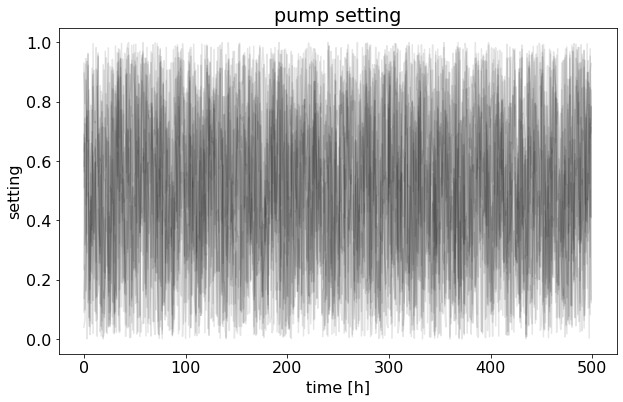

In [13]:
pump_setting = training_in[input_names['pumps']]
pump_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='pump setting', xlabel='time [h]', ylabel='setting')

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

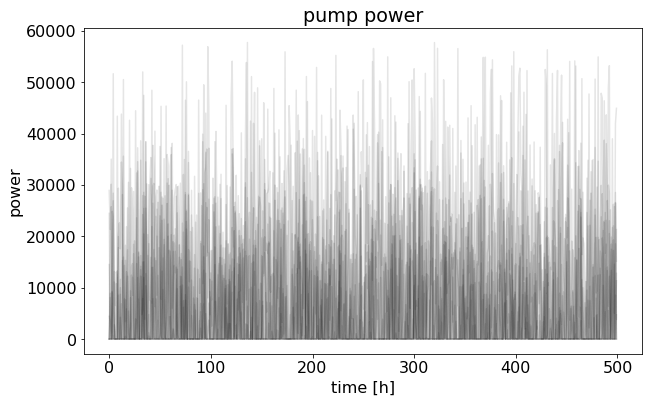

In [14]:
pump_power = training_out[output_names['power']]
pump_power.head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

In [15]:
#data_filter = data_filter & np.all(np.abs(pump_power)<1e6,axis=1) & np.all(pump_power>=0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

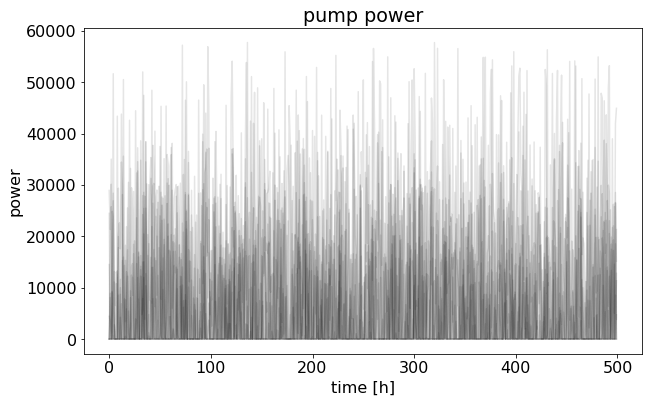

In [16]:
pump_power[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

Let's check the pump_power vs pump_setting after filtering:

Text(0.5, 1.0, 'pump setting vs. power consumption')

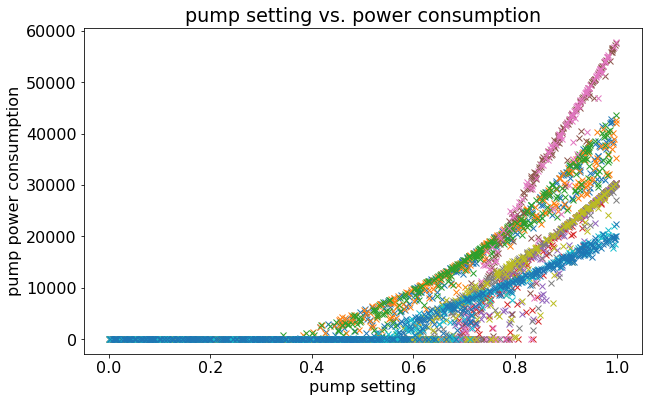

In [17]:
fig, ax = plt.subplots()
ax.plot(pump_setting[data_filter].head(500).to_numpy(), pump_power[data_filter].head(500).to_numpy(), 'x')
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power consumption')
ax.set_title('pump setting vs. power consumption')

### Valves

<AxesSubplot:title={'center':'valve settting'}, xlabel='time [h]', ylabel='setting'>

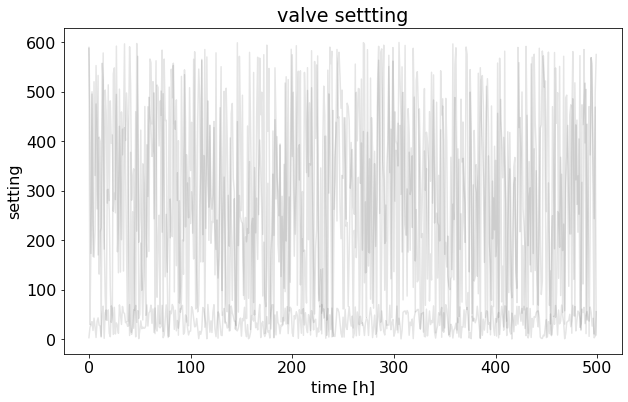

In [18]:
valve_setting = training_in[input_names['valves']]

valve_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='valve settting', xlabel='time [h]', ylabel='setting')

## Neural Network Pre-Processing
### NN inputs:

In [19]:
input_1_dict = {
    'junction_demand': junction_demand[data_filter]
}
nn_inputs_1 = pd.concat(input_1_dict.values(), axis=1, keys=input_1_dict.keys())

input_2_dict = {
    'tank_level': tank_level[data_filter],
}
nn_inputs_2 = pd.concat(input_2_dict.values(), axis=1, keys=input_2_dict.keys())

input_3_dict = {
    'pump_setting': pump_setting[data_filter],                   
    'valve_setting': valve_setting[data_filter]
}
nn_inputs_3 = pd.concat(input_3_dict.values(), axis=1, keys=input_3_dict.keys())

nn_input_dict = {
    'demand': nn_inputs_1,
    'states': nn_inputs_2,
    'inputs': nn_inputs_3,
}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

nn_input.head(2)

demand                                                            \
  junction_demand                                                             
           J511_d    J411_d    J414_d J415_d J416_d    J417_d J418_d J419_d   
0        0.000929  0.000762  0.000828    0.0    0.0  0.001107    0.0    0.0   
1        0.000587  0.000412  0.000447    0.0    0.0  0.000598    0.0    0.0   

                       ...       inputs                                \
                       ... pump_setting                                 
     J310_d    J311_d  ...          PU5       PU6       PU7       PU8   
0  0.001048  0.000913  ...     0.234480  0.040475  0.511187  0.564586   
1  0.000725  0.000631  ...     0.725745  0.064877  0.660430  0.889907   

                                                                      
                                valve_setting                         
        PU9      PU10      PU11           V45         V47         V2  
0  0.929807  0.583212  0.632190    589.815644  587.652053   2.766015  
1  0.098324  0.745180  0.679041    449.815104   29.166241  23.221929  

[2 rows x 409 columns]

### NN outputs:

In [20]:
output_1_dict ={
    'junction_pressure': junction_pressure[data_filter],
}
nn_outputs_1 = pd.concat(output_1_dict.values(), axis=1, keys=output_1_dict.keys())

output_2_dict = {
    'pump_power': pump_power[data_filter],
}
nn_outputs_2 = pd.concat(output_2_dict.values(), axis=1, keys=output_2_dict.keys())

output_3_dict = {
    #'tank_level': dtank_level[data_filter],
    'tank_level': tank_level_next[data_filter]
}
nn_outputs_3 = pd.concat(output_3_dict.values(), axis=1, keys=output_3_dict.keys())

nn_output_dict = {
    'pressure': nn_outputs_1,
    'energy': nn_outputs_2,
    'dstates': nn_outputs_3,
}
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

nn_output.head(2)

pressure                                                         \
  junction_pressure                                                          
             J511_p     J411_p     J414_p     J415_p     J416_p     J417_p   
0         28.516209  63.541023  36.594948  58.643337  81.043335  33.113400   
1         31.023098  65.504532  38.143955  66.849159  89.249161  34.497074   

                                               ...        energy               \
                                               ...    pump_power                
      J418_p     J419_p     J310_p     J311_p  ...         PU9_P       PU10_P   
0  32.755207  29.097137  48.912586  44.836769  ...  24463.834489     0.000000   
1  32.570992  28.920317  54.977676  50.884941  ...      0.000000  8904.443241   

                  dstates                                                    \
               tank_level                                                     
        PU11_P         T3        T1        T7        T6        T5        T2   
0  4406.649493   5.206787  1.131050  0.110612  0.918917  3.902332  3.823541   
1  3395.104302   0.212580  3.900438  4.552819  4.253713  1.549603  3.759254   

             
             
         T4  
0  0.788507  
1  3.105604  

[2 rows x 406 columns]

Filter inputs and outputs. Due to shifting, we introduced `NaN` in the dataframes. These are removed in this step.

In [21]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]
    

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input.shape, nn_output.shape[1]))

n_samples=100000, n_inputs = 409, n_outputs=406


Split into test and train set:

In [22]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = train_test_split(
    nn_input, nn_output, test_size = 0.1
)

In [23]:
input_scaling = nn_input_train.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_train_scaled = nn_input_train/input_scaling
nn_input_test_scaled = nn_input_test/input_scaling

output_scaling = nn_output_train.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_train_scaled = nn_output_train/output_scaling
nn_output_test_scaled = nn_output_test/output_scaling

# DNN Model creation

Create model architecture with input to condense the demand and then input for states control inputs etc.

In [146]:
UnitNorm_cons = tf.keras.constraints.UnitNorm(axis=1)
minmax_cons = tf.keras.constraints.MinMaxNorm(
    min_value=0, max_value=1.0, rate=1.0, axis=1
)
nonneg_cons = tf.keras.constraints.NonNeg()
#nonnegunit_cons =  nonnegUnitNorm(axis=1)

l1_penalty = tf.keras.regularizers.l1(l=0.001)
l2_penalty = tf.keras.regularizers.l2(l=0.01)

In [147]:
n_cluster = 30
n_layer = 4
n_neurons_per_layer = 50

# Input 1 with reduction:
tf_in_1 = tf.keras.Input(shape=(nn_input['demand'].shape[1]), name='demand_in')
tf_in_1_red = tf.keras.layers.Dense(
    n_cluster, 
    name='cluster_demand', 
    use_bias=True,
    #activation=tf.nn.tanh,
    #kernel_regularizer=l1_penalty,
    #kernel_constraint=UnitNorm_cons,
)(tf_in_1)

# Input 2 & 3
tf_in_2 = tf.keras.Input(shape=(nn_input['states'].shape[1],), name='states_in')
tf_in_3 = tf.keras.Input(shape=(nn_input['inputs'].shape[1],), name='inputs_in')

# Concatenating inputs:
tf_in_cat = tf.keras.layers.concatenate([tf_in_1_red, tf_in_2, tf_in_3], name='input_concatenate')

# Intermediate (non-linear) layers:
for i in range(n_layer):
    kernel_regularizer = None
    if i == 0:
        tf_interm = tf.keras.layers.Dense(
            n_neurons_per_layer, 
            activation=tf.nn.tanh, 
            kernel_regularizer = kernel_regularizer,
            name='interm_'+str(i)
        )(tf_in_cat)
    else:
        tf_interm = tf.keras.layers.Dense(
            n_neurons_per_layer, 
            activation=tf.nn.tanh, 
            kernel_regularizer = kernel_regularizer,
            name='interm_'+str(i)
        )(tf_interm)
#         tf_interm = tf.keras.layers.Dropout(
#             .2,
#             name='interm_{}_dropout'.format(i)
#         )(tf_interm)

# splitting:
tf_interm_1 = tf_interm[:,:n_cluster]
tf_interm_2 = tf_interm[:,n_cluster:]

# Linear output layer
tf_out_1 = tf.keras.layers.Dense(
    nn_output['pressure'].shape[1], 
    name='pressure_out', 
    use_bias=True,
    #kernel_constraint=nonneg_cons,
    #kernel_regularizer = l1_penalty,
)(tf_interm_1)

tf_out_2 = tf.keras.layers.Dense(nn_output['energy'].shape[1], name='energy_out')(tf_interm_2)


tf_out_3 = tf.keras.layers.Dense(
    nn_output['dstates'].shape[1], 
    name='dstates_out',
    #kernel_regularizer = l2_penalty,
)(tf_interm_2)

tf_out_3 = tf.keras.layers.add([tf_out_3, tf_in_2], name='states_out')

In [148]:
model = tf.keras.Model(inputs=[tf_in_1, tf_in_2, tf_in_3], outputs=[tf_out_1,tf_out_2, tf_out_3])

In [149]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='mse')

## Model training

In [150]:
x_subset = nn_input_train_scaled.head(20000)
y_subset = nn_output_train_scaled.head(20000)

x_train = [x_subset['demand'], x_subset['states'], x_subset['inputs']]
y_train = [y_subset['pressure'], y_subset['energy'], y_subset['dstates']]
x_test = [nn_input_test_scaled['demand'], nn_input_test_scaled['states'], nn_input_test_scaled['inputs']]
y_test = [nn_output_test_scaled['pressure'], nn_output_test_scaled['energy'], nn_output_test_scaled['dstates']]

history = model.fit(x_train, y_train,
                    batch_size=1000, 
                    epochs=2000)

Epoch 1/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.6461 - pressure_out_loss: 0.4888 - energy_out_loss: 0.1042 - states_out_loss: 0.0532
Epoch 2/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.2067 - pressure_out_loss: 0.1261 - energy_out_loss: 0.0677 - states_out_loss: 0.0129
Epoch 3/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0876 - pressure_out_loss: 0.0146 - energy_out_loss: 0.0632 - states_out_loss: 0.0098
Epoch 4/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0765 - pressure_out_loss: 0.0056 - energy_out_loss: 0.0619 - states_out_loss: 0.0091
Epoch 5/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0740 - pressure_out_loss: 0.0046 - energy_out_loss: 0.0608 - states_out_loss: 0.0087
Epoch 6/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0722 - pressure_out_loss: 0.0044 - energy_out_loss: 0.0593 - states_out_loss: 0.0084
Epoch 7/2000
20/20 [==============

20/20 [==============================] - 0s 8ms/step - loss: 0.0264 - pressure_out_loss: 0.0031 - energy_out_loss: 0.0198 - states_out_loss: 0.0035
Epoch 52/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0263 - pressure_out_loss: 0.0031 - energy_out_loss: 0.0197 - states_out_loss: 0.0035
Epoch 53/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0261 - pressure_out_loss: 0.0031 - energy_out_loss: 0.0196 - states_out_loss: 0.0034
Epoch 54/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0259 - pressure_out_loss: 0.0030 - energy_out_loss: 0.0195 - states_out_loss: 0.0034
Epoch 55/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0257 - pressure_out_loss: 0.0030 - energy_out_loss: 0.0193 - states_out_loss: 0.0034
Epoch 56/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0256 - pressure_out_loss: 0.0030 - energy_out_loss: 0.0192 - states_out_loss: 0.0034
Epoch 57/2000
20/20 [=====================

20/20 [==============================] - 0s 8ms/step - loss: 0.0146 - pressure_out_loss: 0.0023 - energy_out_loss: 0.0098 - states_out_loss: 0.0024
Epoch 102/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0140 - pressure_out_loss: 0.0023 - energy_out_loss: 0.0093 - states_out_loss: 0.0024
Epoch 103/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0136 - pressure_out_loss: 0.0023 - energy_out_loss: 0.0090 - states_out_loss: 0.0023
Epoch 104/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0134 - pressure_out_loss: 0.0023 - energy_out_loss: 0.0088 - states_out_loss: 0.0023
Epoch 105/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0132 - pressure_out_loss: 0.0023 - energy_out_loss: 0.0085 - states_out_loss: 0.0023
Epoch 106/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0131 - pressure_out_loss: 0.0023 - energy_out_loss: 0.0084 - states_out_loss: 0.0024
Epoch 107/2000
20/20 [===============

20/20 [==============================] - 0s 7ms/step - loss: 0.0065 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0029 - states_out_loss: 0.0017
Epoch 152/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0067 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0031 - states_out_loss: 0.0017
Epoch 153/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0071 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0035 - states_out_loss: 0.0018
Epoch 154/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0066 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0030 - states_out_loss: 0.0017
Epoch 155/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0064 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0029 - states_out_loss: 0.0017
Epoch 156/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0065 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0029 - states_out_loss: 0.0017
Epoch 157/2000
20/20 [===============

20/20 [==============================] - 0s 7ms/step - loss: 0.0055 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0023 - states_out_loss: 0.0015
Epoch 202/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0054 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0022 - states_out_loss: 0.0015
Epoch 203/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0054 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0022 - states_out_loss: 0.0015
Epoch 204/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0054 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0022 - states_out_loss: 0.0015
Epoch 205/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0055 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0023 - states_out_loss: 0.0015
Epoch 206/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0054 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0022 - states_out_loss: 0.0015
Epoch 207/2000
20/20 [===============

20/20 [==============================] - 0s 7ms/step - loss: 0.0049 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0019 - states_out_loss: 0.0014
Epoch 252/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0050 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0019 - states_out_loss: 0.0014
Epoch 253/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0049 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0019 - states_out_loss: 0.0014
Epoch 254/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0049 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0019 - states_out_loss: 0.0014
Epoch 255/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0048 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0018 - states_out_loss: 0.0014
Epoch 256/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0048 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0018 - states_out_loss: 0.0014
Epoch 257/2000
20/20 [===============

20/20 [==============================] - 0s 7ms/step - loss: 0.0046 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0017 - states_out_loss: 0.0013
Epoch 302/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0044 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0016 - states_out_loss: 0.0013
Epoch 303/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0043 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0015 - states_out_loss: 0.0013
Epoch 304/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0044 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0016 - states_out_loss: 0.0013
Epoch 305/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0043 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0015 - states_out_loss: 0.0013
Epoch 306/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0044 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0016 - states_out_loss: 0.0013
Epoch 307/2000
20/20 [===============

20/20 [==============================] - 0s 7ms/step - loss: 0.0039 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0014 - states_out_loss: 0.0011
Epoch 352/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0039 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0014 - states_out_loss: 0.0011
Epoch 353/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0039 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0014 - states_out_loss: 0.0011
Epoch 354/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0039 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0014 - states_out_loss: 0.0011
Epoch 355/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0039 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0014 - states_out_loss: 0.0011
Epoch 356/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0038 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0013 - states_out_loss: 0.0010
Epoch 357/2000
20/20 [===============

20/20 [==============================] - 0s 7ms/step - loss: 0.0035 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0013 - states_out_loss: 8.4781e-04
Epoch 401/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0035 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0012 - states_out_loss: 8.2812e-04
Epoch 402/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0034 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0012 - states_out_loss: 8.1868e-04
Epoch 403/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0034 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0012 - states_out_loss: 8.2346e-04
Epoch 404/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0035 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0013 - states_out_loss: 8.2392e-04
Epoch 405/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0035 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0013 - states_out_loss: 8.4102e-04
Epoch 406/200

20/20 [==============================] - 0s 7ms/step - loss: 0.0032 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0011 - states_out_loss: 7.3090e-04
Epoch 449/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0032 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0011 - states_out_loss: 7.3545e-04
Epoch 450/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0032 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0011 - states_out_loss: 7.3627e-04
Epoch 451/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0032 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0011 - states_out_loss: 7.2969e-04
Epoch 452/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0032 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0011 - states_out_loss: 7.3587e-04
Epoch 453/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0032 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0011 - states_out_loss: 7.3080e-04
Epoch 454/200

20/20 [==============================] - 0s 7ms/step - loss: 0.0031 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0010 - states_out_loss: 6.8844e-04
Epoch 498/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0031 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0010 - states_out_loss: 6.9075e-04
Epoch 499/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0031 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0010 - states_out_loss: 6.9345e-04
Epoch 500/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0031 - pressure_out_loss: 0.0014 - energy_out_loss: 0.0010 - states_out_loss: 7.0192e-04
Epoch 501/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0030 - pressure_out_loss: 0.0014 - energy_out_loss: 9.9252e-04 - states_out_loss: 6.8365e-04
Epoch 502/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0030 - pressure_out_loss: 0.0014 - energy_out_loss: 9.8462e-04 - states_out_loss: 6.7650e-04
Epoch

20/20 [==============================] - 0s 7ms/step - loss: 0.0029 - pressure_out_loss: 0.0013 - energy_out_loss: 9.1968e-04 - states_out_loss: 6.4435e-04
Epoch 546/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0029 - pressure_out_loss: 0.0013 - energy_out_loss: 9.3070e-04 - states_out_loss: 6.4379e-04
Epoch 547/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0029 - pressure_out_loss: 0.0013 - energy_out_loss: 9.3755e-04 - states_out_loss: 6.6487e-04
Epoch 548/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0029 - pressure_out_loss: 0.0013 - energy_out_loss: 9.1887e-04 - states_out_loss: 6.4218e-04
Epoch 549/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0029 - pressure_out_loss: 0.0013 - energy_out_loss: 9.2338e-04 - states_out_loss: 6.4278e-04
Epoch 550/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0029 - pressure_out_loss: 0.0013 - energy_out_loss: 9.3890e-04 - states_out_loss: 

Epoch 593/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0028 - pressure_out_loss: 0.0013 - energy_out_loss: 8.8645e-04 - states_out_loss: 6.0971e-04
Epoch 594/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0028 - pressure_out_loss: 0.0013 - energy_out_loss: 8.8732e-04 - states_out_loss: 5.9560e-04
Epoch 595/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0027 - pressure_out_loss: 0.0013 - energy_out_loss: 8.8478e-04 - states_out_loss: 5.9031e-04
Epoch 596/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0027 - pressure_out_loss: 0.0013 - energy_out_loss: 8.7484e-04 - states_out_loss: 5.9097e-04
Epoch 597/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0027 - pressure_out_loss: 0.0013 - energy_out_loss: 8.8047e-04 - states_out_loss: 5.9038e-04
Epoch 598/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0028 - pressure_out_loss: 0.0013 - energy_out_loss: 9.0454e-04 - st

20/20 [==============================] - 0s 7ms/step - loss: 0.0026 - pressure_out_loss: 0.0012 - energy_out_loss: 8.3105e-04 - states_out_loss: 5.7041e-04
Epoch 641/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0026 - pressure_out_loss: 0.0012 - energy_out_loss: 8.1982e-04 - states_out_loss: 5.5078e-04
Epoch 642/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0026 - pressure_out_loss: 0.0012 - energy_out_loss: 8.0511e-04 - states_out_loss: 5.4823e-04
Epoch 643/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0026 - pressure_out_loss: 0.0012 - energy_out_loss: 8.0494e-04 - states_out_loss: 5.6052e-04
Epoch 644/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0026 - pressure_out_loss: 0.0012 - energy_out_loss: 8.2569e-04 - states_out_loss: 5.4777e-04
Epoch 645/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0026 - pressure_out_loss: 0.0012 - energy_out_loss: 8.2819e-04 - states_out_loss: 

Epoch 688/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0024 - pressure_out_loss: 0.0011 - energy_out_loss: 7.5801e-04 - states_out_loss: 5.2562e-04
Epoch 689/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0024 - pressure_out_loss: 0.0011 - energy_out_loss: 7.6555e-04 - states_out_loss: 5.3404e-04
Epoch 690/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0025 - pressure_out_loss: 0.0011 - energy_out_loss: 7.8674e-04 - states_out_loss: 5.4169e-04
Epoch 691/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0025 - pressure_out_loss: 0.0011 - energy_out_loss: 7.6307e-04 - states_out_loss: 5.5822e-04
Epoch 692/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0024 - pressure_out_loss: 0.0011 - energy_out_loss: 7.5837e-04 - states_out_loss: 5.2911e-04
Epoch 693/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0024 - pressure_out_loss: 0.0011 - energy_out_loss: 7.6158e-04 - st

20/20 [==============================] - 0s 7ms/step - loss: 0.0023 - pressure_out_loss: 0.0010 - energy_out_loss: 7.2169e-04 - states_out_loss: 5.0283e-04
Epoch 736/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0023 - pressure_out_loss: 0.0010 - energy_out_loss: 7.4927e-04 - states_out_loss: 5.0736e-04
Epoch 737/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0023 - pressure_out_loss: 0.0010 - energy_out_loss: 7.4348e-04 - states_out_loss: 5.2422e-04
Epoch 738/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0023 - pressure_out_loss: 0.0010 - energy_out_loss: 7.4379e-04 - states_out_loss: 5.3006e-04
Epoch 739/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0023 - pressure_out_loss: 0.0010 - energy_out_loss: 7.3356e-04 - states_out_loss: 5.0443e-04
Epoch 740/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0023 - pressure_out_loss: 0.0010 - energy_out_loss: 7.3198e-04 - states_out_loss: 

20/20 [==============================] - 0s 7ms/step - loss: 0.0021 - pressure_out_loss: 9.8249e-04 - energy_out_loss: 6.9293e-04 - states_out_loss: 4.5567e-04
Epoch 783/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0021 - pressure_out_loss: 9.8598e-04 - energy_out_loss: 6.9847e-04 - states_out_loss: 4.6088e-04
Epoch 784/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0022 - pressure_out_loss: 9.9673e-04 - energy_out_loss: 7.2173e-04 - states_out_loss: 4.9819e-04
Epoch 785/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0022 - pressure_out_loss: 9.8440e-04 - energy_out_loss: 6.9581e-04 - states_out_loss: 4.7174e-04
Epoch 786/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0022 - pressure_out_loss: 9.8096e-04 - energy_out_loss: 7.1101e-04 - states_out_loss: 4.6344e-04
Epoch 787/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0022 - pressure_out_loss: 9.8818e-04 - energy_out_loss: 7.0474

20/20 [==============================] - 0s 8ms/step - loss: 0.0021 - pressure_out_loss: 9.5129e-04 - energy_out_loss: 6.7538e-04 - states_out_loss: 4.5534e-04
Epoch 829/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0021 - pressure_out_loss: 9.5143e-04 - energy_out_loss: 6.7446e-04 - states_out_loss: 4.5184e-04
Epoch 830/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0020 - pressure_out_loss: 9.4234e-04 - energy_out_loss: 6.6274e-04 - states_out_loss: 4.3660e-04
Epoch 831/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0021 - pressure_out_loss: 9.4639e-04 - energy_out_loss: 6.7421e-04 - states_out_loss: 4.4175e-04
Epoch 832/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0021 - pressure_out_loss: 9.4089e-04 - energy_out_loss: 6.7477e-04 - states_out_loss: 4.3727e-04
Epoch 833/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0021 - pressure_out_loss: 9.4403e-04 - energy_out_loss: 6.7228

20/20 [==============================] - 0s 8ms/step - loss: 0.0019 - pressure_out_loss: 8.6900e-04 - energy_out_loss: 6.4877e-04 - states_out_loss: 4.2020e-04
Epoch 875/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0020 - pressure_out_loss: 8.7064e-04 - energy_out_loss: 6.5316e-04 - states_out_loss: 4.2992e-04
Epoch 876/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0020 - pressure_out_loss: 8.7041e-04 - energy_out_loss: 6.4777e-04 - states_out_loss: 4.3652e-04
Epoch 877/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0020 - pressure_out_loss: 8.6516e-04 - energy_out_loss: 6.5698e-04 - states_out_loss: 4.3179e-04
Epoch 878/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0020 - pressure_out_loss: 8.6791e-04 - energy_out_loss: 6.5366e-04 - states_out_loss: 4.3042e-04
Epoch 879/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0020 - pressure_out_loss: 8.6657e-04 - energy_out_loss: 6.5639

20/20 [==============================] - 0s 7ms/step - loss: 0.0019 - pressure_out_loss: 8.3686e-04 - energy_out_loss: 6.4560e-04 - states_out_loss: 4.1712e-04
Epoch 921/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0019 - pressure_out_loss: 8.3102e-04 - energy_out_loss: 6.3422e-04 - states_out_loss: 4.1408e-04
Epoch 922/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0019 - pressure_out_loss: 8.3405e-04 - energy_out_loss: 6.3428e-04 - states_out_loss: 4.2392e-04
Epoch 923/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0019 - pressure_out_loss: 8.2942e-04 - energy_out_loss: 6.2899e-04 - states_out_loss: 4.1126e-04
Epoch 924/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0019 - pressure_out_loss: 8.2863e-04 - energy_out_loss: 6.2231e-04 - states_out_loss: 4.1097e-04
Epoch 925/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0019 - pressure_out_loss: 8.2726e-04 - energy_out_loss: 6.2680

20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 8.1668e-04 - energy_out_loss: 6.2044e-04 - states_out_loss: 4.0459e-04
Epoch 967/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 8.1548e-04 - energy_out_loss: 6.2152e-04 - states_out_loss: 4.0691e-04
Epoch 968/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 8.1257e-04 - energy_out_loss: 6.1188e-04 - states_out_loss: 4.0468e-04
Epoch 969/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 8.1010e-04 - energy_out_loss: 6.0950e-04 - states_out_loss: 4.0278e-04
Epoch 970/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 8.1390e-04 - energy_out_loss: 6.2292e-04 - states_out_loss: 4.0229e-04
Epoch 971/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 8.1587e-04 - energy_out_loss: 6.1271

20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 8.0104e-04 - energy_out_loss: 5.9252e-04 - states_out_loss: 3.9017e-04
Epoch 1013/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 7.9908e-04 - energy_out_loss: 5.9864e-04 - states_out_loss: 3.9180e-04
Epoch 1014/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 7.9917e-04 - energy_out_loss: 5.9183e-04 - states_out_loss: 3.9362e-04
Epoch 1015/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 7.9679e-04 - energy_out_loss: 5.9377e-04 - states_out_loss: 3.9158e-04
Epoch 1016/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 8.0221e-04 - energy_out_loss: 6.0732e-04 - states_out_loss: 4.0947e-04
Epoch 1017/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 8.0686e-04 - energy_out_loss: 6

20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.8435e-04 - energy_out_loss: 5.7134e-04 - states_out_loss: 3.7740e-04
Epoch 1059/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.8536e-04 - energy_out_loss: 5.7692e-04 - states_out_loss: 3.7919e-04
Epoch 1060/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.8436e-04 - energy_out_loss: 5.7421e-04 - states_out_loss: 3.7791e-04
Epoch 1061/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.8694e-04 - energy_out_loss: 5.7443e-04 - states_out_loss: 3.7852e-04
Epoch 1062/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.9043e-04 - energy_out_loss: 5.7693e-04 - states_out_loss: 3.8076e-04
Epoch 1063/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0018 - pressure_out_loss: 7.8672e-04 - energy_out_loss: 5

20/20 [==============================] - 0s 8ms/step - loss: 0.0017 - pressure_out_loss: 7.8207e-04 - energy_out_loss: 5.5896e-04 - states_out_loss: 3.7070e-04
Epoch 1105/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.8068e-04 - energy_out_loss: 5.6075e-04 - states_out_loss: 3.7272e-04
Epoch 1106/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.7821e-04 - energy_out_loss: 5.5388e-04 - states_out_loss: 3.6209e-04
Epoch 1107/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0017 - pressure_out_loss: 7.7830e-04 - energy_out_loss: 5.5512e-04 - states_out_loss: 3.6603e-04
Epoch 1108/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.7978e-04 - energy_out_loss: 5.5241e-04 - states_out_loss: 3.7107e-04
Epoch 1109/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.7600e-04 - energy_out_loss: 5

20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.7256e-04 - energy_out_loss: 5.4914e-04 - states_out_loss: 3.5910e-04
Epoch 1151/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0017 - pressure_out_loss: 7.7640e-04 - energy_out_loss: 5.4654e-04 - states_out_loss: 3.6841e-04
Epoch 1152/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0017 - pressure_out_loss: 7.7356e-04 - energy_out_loss: 5.3638e-04 - states_out_loss: 3.6226e-04
Epoch 1153/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0017 - pressure_out_loss: 7.6865e-04 - energy_out_loss: 5.3785e-04 - states_out_loss: 3.4576e-04
Epoch 1154/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0017 - pressure_out_loss: 7.7195e-04 - energy_out_loss: 5.4028e-04 - states_out_loss: 3.5034e-04
Epoch 1155/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0016 - pressure_out_loss: 7.6697e-04 - energy_out_loss: 5

20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.6206e-04 - energy_out_loss: 5.2173e-04 - states_out_loss: 3.3259e-04
Epoch 1197/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.5997e-04 - energy_out_loss: 5.2253e-04 - states_out_loss: 3.3682e-04
Epoch 1198/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.6741e-04 - energy_out_loss: 5.3877e-04 - states_out_loss: 3.3972e-04
Epoch 1199/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.6293e-04 - energy_out_loss: 5.3572e-04 - states_out_loss: 3.3598e-04
Epoch 1200/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.6288e-04 - energy_out_loss: 5.2270e-04 - states_out_loss: 3.3354e-04
Epoch 1201/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.5972e-04 - energy_out_loss: 5

20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.5348e-04 - energy_out_loss: 5.0681e-04 - states_out_loss: 3.1843e-04
Epoch 1243/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.5513e-04 - energy_out_loss: 5.1022e-04 - states_out_loss: 3.2220e-04
Epoch 1244/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.5220e-04 - energy_out_loss: 5.0551e-04 - states_out_loss: 3.1652e-04
Epoch 1245/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.5413e-04 - energy_out_loss: 5.0918e-04 - states_out_loss: 3.1886e-04
Epoch 1246/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.5496e-04 - energy_out_loss: 5.1639e-04 - states_out_loss: 3.2797e-04
Epoch 1247/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.5675e-04 - energy_out_loss: 5

20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.5017e-04 - energy_out_loss: 4.9251e-04 - states_out_loss: 3.0277e-04
Epoch 1289/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.5135e-04 - energy_out_loss: 4.9210e-04 - states_out_loss: 3.0985e-04
Epoch 1290/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.5115e-04 - energy_out_loss: 4.9968e-04 - states_out_loss: 3.1329e-04
Epoch 1291/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.4809e-04 - energy_out_loss: 5.0231e-04 - states_out_loss: 3.0742e-04
Epoch 1292/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.4853e-04 - energy_out_loss: 4.9925e-04 - states_out_loss: 3.0536e-04
Epoch 1293/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0016 - pressure_out_loss: 7.4935e-04 - energy_out_loss: 4

20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4583e-04 - energy_out_loss: 4.8132e-04 - states_out_loss: 2.9793e-04
Epoch 1335/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4580e-04 - energy_out_loss: 4.7608e-04 - states_out_loss: 2.9670e-04
Epoch 1336/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4532e-04 - energy_out_loss: 4.7882e-04 - states_out_loss: 2.9835e-04
Epoch 1337/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4808e-04 - energy_out_loss: 4.8296e-04 - states_out_loss: 2.9824e-04
Epoch 1338/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4769e-04 - energy_out_loss: 4.8359e-04 - states_out_loss: 3.0014e-04
Epoch 1339/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4544e-04 - energy_out_loss: 4

20/20 [==============================] - 0s 8ms/step - loss: 0.0015 - pressure_out_loss: 7.4083e-04 - energy_out_loss: 4.6273e-04 - states_out_loss: 2.9109e-04
Epoch 1381/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4333e-04 - energy_out_loss: 4.6351e-04 - states_out_loss: 2.8804e-04
Epoch 1382/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0015 - pressure_out_loss: 7.4225e-04 - energy_out_loss: 4.6146e-04 - states_out_loss: 2.9015e-04
Epoch 1383/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4639e-04 - energy_out_loss: 4.5752e-04 - states_out_loss: 3.0144e-04
Epoch 1384/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4157e-04 - energy_out_loss: 4.5470e-04 - states_out_loss: 2.9322e-04
Epoch 1385/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4057e-04 - energy_out_loss: 4

20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.3879e-04 - energy_out_loss: 4.4248e-04 - states_out_loss: 2.8251e-04
Epoch 1427/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0015 - pressure_out_loss: 7.3976e-04 - energy_out_loss: 4.4021e-04 - states_out_loss: 2.8541e-04
Epoch 1428/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0015 - pressure_out_loss: 7.4248e-04 - energy_out_loss: 4.3862e-04 - states_out_loss: 2.8867e-04
Epoch 1429/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0015 - pressure_out_loss: 7.4057e-04 - energy_out_loss: 4.4414e-04 - states_out_loss: 2.8777e-04
Epoch 1430/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0015 - pressure_out_loss: 7.4128e-04 - energy_out_loss: 4.4273e-04 - states_out_loss: 2.8836e-04
Epoch 1431/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.3822e-04 - energy_out_loss: 4

20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.4135e-04 - energy_out_loss: 4.3136e-04 - states_out_loss: 2.8126e-04
Epoch 1473/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.3999e-04 - energy_out_loss: 4.2730e-04 - states_out_loss: 2.8508e-04
Epoch 1474/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0015 - pressure_out_loss: 7.3580e-04 - energy_out_loss: 4.3521e-04 - states_out_loss: 2.8321e-04
Epoch 1475/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3511e-04 - energy_out_loss: 4.3098e-04 - states_out_loss: 2.7816e-04
Epoch 1476/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3310e-04 - energy_out_loss: 4.2576e-04 - states_out_loss: 2.7446e-04
Epoch 1477/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3521e-04 - energy_out_loss: 4

20/20 [==============================] - 0s 8ms/step - loss: 0.0014 - pressure_out_loss: 7.3610e-04 - energy_out_loss: 4.1106e-04 - states_out_loss: 2.7615e-04
Epoch 1519/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0014 - pressure_out_loss: 7.3200e-04 - energy_out_loss: 4.0735e-04 - states_out_loss: 2.7564e-04
Epoch 1520/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0014 - pressure_out_loss: 7.3217e-04 - energy_out_loss: 4.1391e-04 - states_out_loss: 2.7635e-04
Epoch 1521/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0014 - pressure_out_loss: 7.3491e-04 - energy_out_loss: 4.1031e-04 - states_out_loss: 2.7316e-04
Epoch 1522/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0014 - pressure_out_loss: 7.3198e-04 - energy_out_loss: 4.0884e-04 - states_out_loss: 2.7218e-04
Epoch 1523/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0014 - pressure_out_loss: 7.3967e-04 - energy_out_loss: 4

20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3094e-04 - energy_out_loss: 3.9427e-04 - states_out_loss: 2.6679e-04
Epoch 1565/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3313e-04 - energy_out_loss: 3.9944e-04 - states_out_loss: 2.7142e-04
Epoch 1566/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0014 - pressure_out_loss: 7.3356e-04 - energy_out_loss: 4.0382e-04 - states_out_loss: 2.7302e-04
Epoch 1567/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3354e-04 - energy_out_loss: 3.9799e-04 - states_out_loss: 2.7019e-04
Epoch 1568/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3517e-04 - energy_out_loss: 3.9197e-04 - states_out_loss: 2.7021e-04
Epoch 1569/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0014 - pressure_out_loss: 7.3082e-04 - energy_out_loss: 3

20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3107e-04 - energy_out_loss: 3.8069e-04 - states_out_loss: 2.6628e-04
Epoch 1611/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3210e-04 - energy_out_loss: 3.8216e-04 - states_out_loss: 2.6915e-04
Epoch 1612/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3066e-04 - energy_out_loss: 3.8237e-04 - states_out_loss: 2.6927e-04
Epoch 1613/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.2900e-04 - energy_out_loss: 3.8095e-04 - states_out_loss: 2.6482e-04
Epoch 1614/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3133e-04 - energy_out_loss: 3.8354e-04 - states_out_loss: 2.6667e-04
Epoch 1615/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.2970e-04 - energy_out_loss: 3

20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.2821e-04 - energy_out_loss: 3.6757e-04 - states_out_loss: 2.5950e-04
Epoch 1657/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.2899e-04 - energy_out_loss: 3.6984e-04 - states_out_loss: 2.6028e-04
Epoch 1658/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.2821e-04 - energy_out_loss: 3.6547e-04 - states_out_loss: 2.5977e-04
Epoch 1659/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.2808e-04 - energy_out_loss: 3.6479e-04 - states_out_loss: 2.5815e-04
Epoch 1660/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.2798e-04 - energy_out_loss: 3.7083e-04 - states_out_loss: 2.6085e-04
Epoch 1661/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.2866e-04 - energy_out_loss: 3

20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2701e-04 - energy_out_loss: 3.5764e-04 - states_out_loss: 2.5104e-04
Epoch 1703/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2681e-04 - energy_out_loss: 3.5753e-04 - states_out_loss: 2.5548e-04
Epoch 1704/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2639e-04 - energy_out_loss: 3.6204e-04 - states_out_loss: 2.5188e-04
Epoch 1705/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0014 - pressure_out_loss: 7.3153e-04 - energy_out_loss: 3.6377e-04 - states_out_loss: 2.5514e-04
Epoch 1706/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.3041e-04 - energy_out_loss: 3.6097e-04 - states_out_loss: 2.5638e-04
Epoch 1707/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2853e-04 - energy_out_loss: 3

20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2744e-04 - energy_out_loss: 3.5137e-04 - states_out_loss: 2.5012e-04
Epoch 1749/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.3082e-04 - energy_out_loss: 3.5112e-04 - states_out_loss: 2.5495e-04
Epoch 1750/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2764e-04 - energy_out_loss: 3.5807e-04 - states_out_loss: 2.5269e-04
Epoch 1751/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2577e-04 - energy_out_loss: 3.4655e-04 - states_out_loss: 2.4971e-04
Epoch 1752/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2858e-04 - energy_out_loss: 3.4428e-04 - states_out_loss: 2.5239e-04
Epoch 1753/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2883e-04 - energy_out_loss: 3

20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2435e-04 - energy_out_loss: 3.3378e-04 - states_out_loss: 2.4564e-04
Epoch 1795/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2616e-04 - energy_out_loss: 3.3194e-04 - states_out_loss: 2.4537e-04
Epoch 1796/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2428e-04 - energy_out_loss: 3.3212e-04 - states_out_loss: 2.4259e-04
Epoch 1797/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2328e-04 - energy_out_loss: 3.3653e-04 - states_out_loss: 2.4207e-04
Epoch 1798/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2372e-04 - energy_out_loss: 3.3037e-04 - states_out_loss: 2.4417e-04
Epoch 1799/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2278e-04 - energy_out_loss: 3

20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2447e-04 - energy_out_loss: 3.2827e-04 - states_out_loss: 2.4131e-04
Epoch 1841/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2491e-04 - energy_out_loss: 3.2572e-04 - states_out_loss: 2.4016e-04
Epoch 1842/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2865e-04 - energy_out_loss: 3.2794e-04 - states_out_loss: 2.4255e-04
Epoch 1843/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2442e-04 - energy_out_loss: 3.2652e-04 - states_out_loss: 2.3988e-04
Epoch 1844/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2476e-04 - energy_out_loss: 3.2520e-04 - states_out_loss: 2.3757e-04
Epoch 1845/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.3056e-04 - energy_out_loss: 3

20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2269e-04 - energy_out_loss: 3.1641e-04 - states_out_loss: 2.3125e-04
Epoch 1887/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2310e-04 - energy_out_loss: 3.1646e-04 - states_out_loss: 2.3576e-04
Epoch 1888/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2538e-04 - energy_out_loss: 3.2015e-04 - states_out_loss: 2.3734e-04
Epoch 1889/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2476e-04 - energy_out_loss: 3.1990e-04 - states_out_loss: 2.3799e-04
Epoch 1890/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2398e-04 - energy_out_loss: 3.1324e-04 - states_out_loss: 2.3562e-04
Epoch 1891/2000
20/20 [==============================] - 0s 7ms/step - loss: 0.0013 - pressure_out_loss: 7.2459e-04 - energy_out_loss: 3

20/20 [==============================] - 0s 11ms/step - loss: 0.0013 - pressure_out_loss: 7.1993e-04 - energy_out_loss: 3.1147e-04 - states_out_loss: 2.2641e-04
Epoch 1933/2000
20/20 [==============================] - 0s 12ms/step - loss: 0.0013 - pressure_out_loss: 7.2302e-04 - energy_out_loss: 3.1295e-04 - states_out_loss: 2.3182e-04
Epoch 1934/2000
20/20 [==============================] - 0s 12ms/step - loss: 0.0013 - pressure_out_loss: 7.2231e-04 - energy_out_loss: 3.1057e-04 - states_out_loss: 2.2773e-04
Epoch 1935/2000
20/20 [==============================] - 0s 9ms/step - loss: 0.0013 - pressure_out_loss: 7.2059e-04 - energy_out_loss: 3.0466e-04 - states_out_loss: 2.2567e-04
Epoch 1936/2000
20/20 [==============================] - 0s 9ms/step - loss: 0.0013 - pressure_out_loss: 7.2459e-04 - energy_out_loss: 3.1356e-04 - states_out_loss: 2.3175e-04
Epoch 1937/2000
20/20 [==============================] - 0s 10ms/step - loss: 0.0013 - pressure_out_loss: 7.2556e-04 - energy_out_los

20/20 [==============================] - 0s 8ms/step - loss: 0.0013 - pressure_out_loss: 7.2436e-04 - energy_out_loss: 3.0136e-04 - states_out_loss: 2.2935e-04
Epoch 1979/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0012 - pressure_out_loss: 7.2222e-04 - energy_out_loss: 3.0448e-04 - states_out_loss: 2.2323e-04
Epoch 1980/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0012 - pressure_out_loss: 7.2149e-04 - energy_out_loss: 3.0285e-04 - states_out_loss: 2.2090e-04
Epoch 1981/2000
20/20 [==============================] - 0s 8ms/step - loss: 0.0012 - pressure_out_loss: 7.2036e-04 - energy_out_loss: 2.9918e-04 - states_out_loss: 2.1879e-04
Epoch 1982/2000
20/20 [==============================] - 0s 9ms/step - loss: 0.0012 - pressure_out_loss: 7.2152e-04 - energy_out_loss: 2.9694e-04 - states_out_loss: 2.1657e-04
Epoch 1983/2000
20/20 [==============================] - 0s 9ms/step - loss: 0.0013 - pressure_out_loss: 7.2364e-04 - energy_out_loss: 3

In [151]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 759us/step - loss: 0.0013 - pressure_out_loss: 7.4517e-04 - energy_out_loss: 3.1520e-04 - states_out_loss: 2.2164e-04


[0.0012820027768611908,
 0.0007451674318872392,
 0.00031519573531113565,
 0.0002216393913840875]

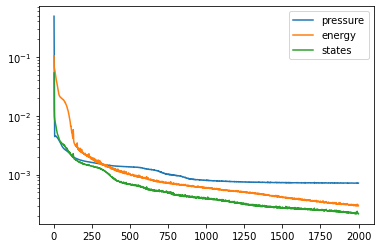

In [169]:
plt.semilogy(history.epoch,history.history['pressure_out_loss'], label='pressure')
plt.semilogy(history.epoch,history.history['energy_out_loss'], label='energy')
plt.semilogy(history.epoch,history.history['states_out_loss'], label='states')
plt.legend()

In [32]:
A_cluster = model.get_layer('cluster_demand').get_weights()[0]

# Validation data

In [33]:
file = './validation/surrModel_scenarioDB_ruleBased_altControl.pkl'
with open(file, 'rb') as f:
    validation = pickle.load(f)

In [34]:
output_names.keys()

dict_keys(['pressure', 'tanks', 'power'])

In [35]:
val_demand = validation['input'][input_names['demand']]
val_states = validation['input'][input_names['tanks']]
val_inputs = validation['input'][input_names['pumps']+input_names['valves']]

val_pressure = validation['output'][output_names['pressure']]
val_energy = validation['output'][output_names['power']]

<AxesSubplot:>

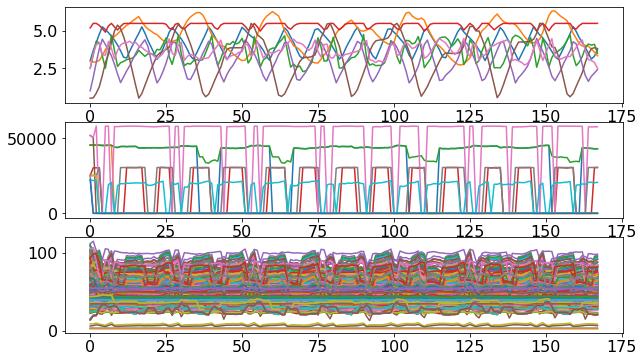

In [36]:
fig,ax = plt.subplots(3,1)
val_states.plot(ax=ax[0], legend=False)
val_energy.plot(ax=ax[1], legend=False)
val_pressure.plot(ax=ax[2], legend=False)

Text(0, 0.5, 'pump power ')

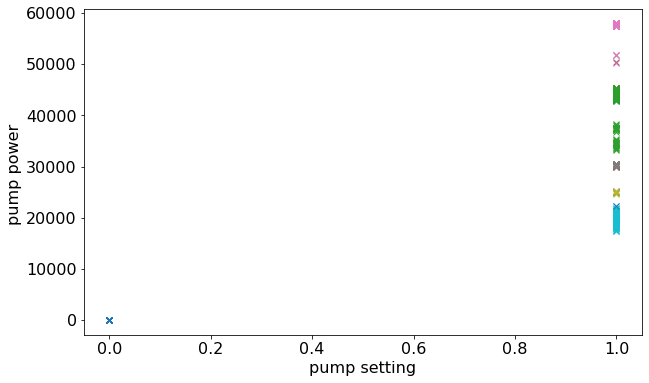

In [37]:
fig, ax = plt.subplots()
ax.plot(
    val_inputs[input_names['pumps']],
    val_energy[output_names['power']],
    'x'
)
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power ')

### Simulation evaluation

In [38]:
from IPython.display import clear_output, display

In [39]:
val_demand_np = val_demand.to_numpy()
val_states_np = val_states.to_numpy()
val_inputs_np = val_inputs.to_numpy()

in_d_scaling = input_scaling['demand'].to_numpy()
in_s_scaling = input_scaling['states'].to_numpy()
in_i_scaling = input_scaling['inputs'].to_numpy()

out_p_scaling = output_scaling['pressure'].to_numpy()
out_e_scaling = output_scaling['energy'].to_numpy()
out_s_scaling = output_scaling['dstates'].to_numpy()

Open loop simulation of the Neural Network

In [170]:
est_states = [val_states_np[[0]]]
est_pressure = []
est_energy = []

for k in range(val_inputs_np.shape[0]-1):
    clear_output(wait=True)
    print(k)
    demand_k = val_demand_np[[k],:]
    states_k = est_states[k]
    inputs_k = val_inputs_np[[k],:]
    
    demand_k_scaled = demand_k/in_d_scaling
    states_k_scaled = states_k/in_s_scaling
    inputs_k_scaled = inputs_k/in_i_scaling

    pressure_scaled, energy_scaled, dstates_scaled = model.predict([demand_k_scaled, states_k_scaled, inputs_k_scaled])
    
    pressure_k = pressure_scaled * out_p_scaling
    energy_k = energy_scaled * out_e_scaling
    #states_k_next = states_k + dstates_scaled * out_s_scaling
    states_k_next = dstates_scaled * out_s_scaling
    
    ### Achtung ENTFERNEN!!!!!!
    #states_k_next = val_states_np[[k+1]]
    #states_k_next = np.minimum(np.maximum(states_k_next,0),7)
    
    est_states.append(states_k_next)
    est_energy.append(energy_k)
    est_pressure.append(pressure_k)

est_pressure = np.concatenate(est_pressure,axis=0)
est_energy = np.concatenate(est_energy,axis=0)
est_states = np.concatenate(est_states,axis=0)

est_pressure_df = pd.DataFrame(data=est_pressure, index=val_pressure.index[:-1], columns=val_pressure.keys())
est_energy_df = pd.DataFrame(data=est_energy, index=val_energy.index[:-1], columns=val_energy.keys())
est_states_df = pd.DataFrame(data=est_states, index=val_states.index, columns=val_states.keys())

166


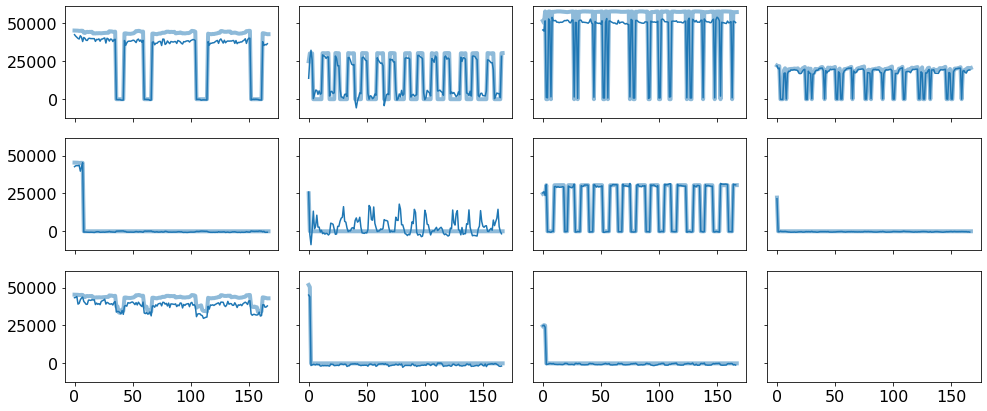

In [160]:
fig,ax = plt.subplots(3,4, figsize=(14,6), sharey=True, sharex=True)

for k,name in enumerate(val_energy.keys()):
    i,j = k%3,k//3
    
    val_energy[name].plot(legend=False, ax=ax[i,j],linewidth=4, alpha=.5)
    ax[i,j].set_prop_cycle(None)
    est_energy_df[name].plot(legend=False, ax=ax[i,j])

fig.tight_layout()
    

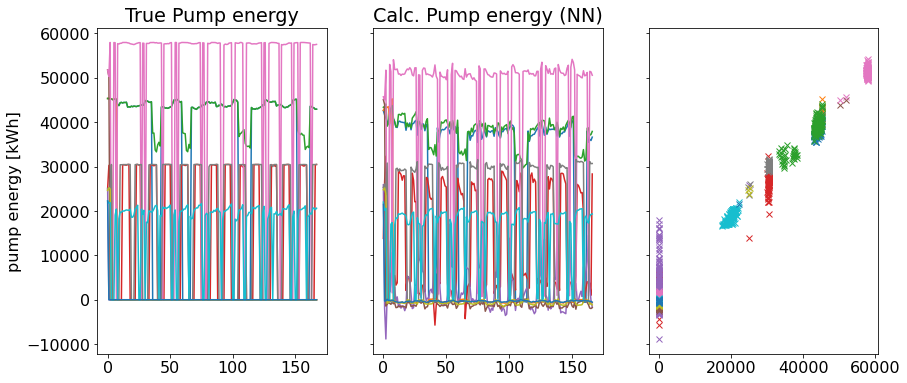

In [161]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_energy.plot(legend=False, ax=ax[0])
ax[1].plot(est_energy)
ax[0].set_title('True Pump energy')
ax[1].set_title('Calc. Pump energy (NN)')
ax[0].set_ylabel('pump energy [kWh]')

ax[2].plot(val_energy.to_numpy()[:-1,:], est_energy, 'x')

plt.show()

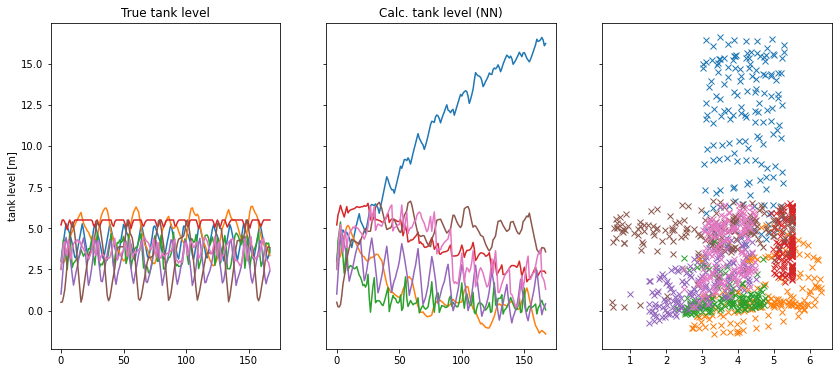

In [171]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.plot(legend=False, ax=ax[0])
ax[1].plot(est_states)
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states,est_states,'x')



plt.show()

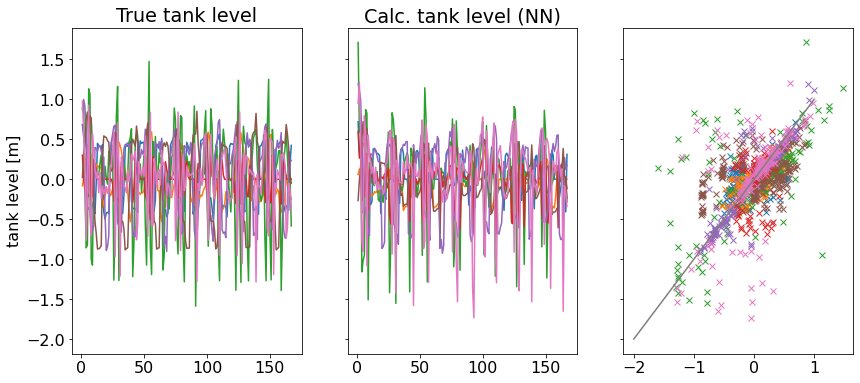

In [163]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.diff().plot(legend=False, ax=ax[0])
est_states_df.diff().plot(legend=False, ax=ax[1])
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states.diff(), est_states_df.diff(),'x')
ax[2].plot([-2,1],[-2,1])

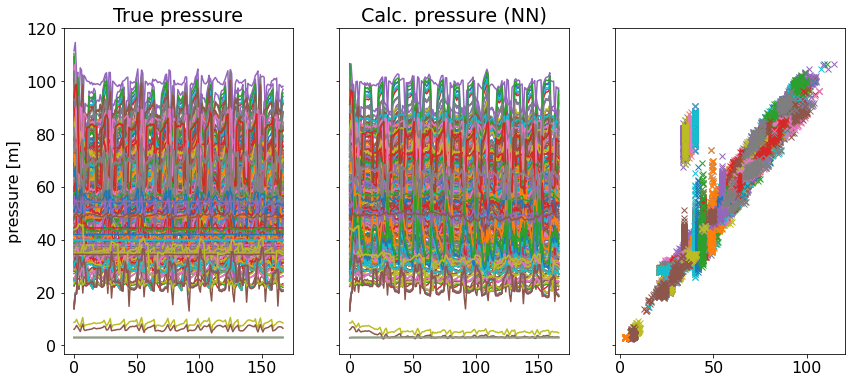

In [164]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_pressure.plot(legend=False, ax=ax[0])
ax[1].plot(est_pressure)
ax[0].set_title('True pressure')
ax[1].set_title('Calc. pressure (NN)')
ax[0].set_ylabel('pressure [m]')
ax[2].plot(val_pressure.to_numpy()[:-1,:],est_pressure, 'x')
plt.show()